# 適性


* Use TrueSkill to calculate the rating per condition, then take the average and use this as a "適性" score.
  * https://chat.openai.com/c/61cab01d-8eb8-4351-a54a-090a4412ad7b
* Also include competitor scores
* Also check how the 適性 score differs from the normal rating.


Todo: Also adjust the TrueSkill rating to account for the magnitude of the win. (e.g. if the win is by a large margin, the rating should be higher)
ChatGPT is recommending pyglicko2 for this. See above chat.

Maybe you shouldn't be look at weighed position, rather weighted finish time difference from 3rd placing horse. Weighted finish time difference from 3rd placing horse would take into account the magnitude of win/loss.

Idea: Calculate trueskill race quality and place bets on the most uneven races.
=> Did not work

Todo: Analyze the characteristics of the races you're predicting well and failing to predict well. Target races you're strong at.

Race quality IS a good factor in the prediction.

In [1]:
import re
import tempfile
import warnings

import japanize_matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import shap
import trueskill
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from JapanHorseRaceAnalytics.utilities.base import (
    get_random_seed,
    get_spark_session,
    read_hive_table,
)
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_payout_rate,
    kelly_criterion,
)
from JapanHorseRaceAnalytics.utilities.plot import (
    plot_confusion_matrix,
    plot_correlation_matrix,
    plot_feature_importances,
    plot_roc_curve,
    plot_shap_interaction_values,
)
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

japanize_matplotlib.japanize()

In [2]:
spark = get_spark_session()

24/03/21 06:49:57 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/03/21 06:49:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/21 06:49:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
    parse_dates=["meta_発走日時"],
)

rows_before = data.shape[0]
logger.info(f"Original data length: {rows_before}")

# Drop from data where cat_トラック種別 == "障害"
# Keep only horses that have 3 races
# Keep only data from 2000 onwards
data = data[
    # (data["cat_トラック種別"] != "障害")
    (~data["meta_着順"].isna())
    # & (data["meta_異常区分"] == "0")
    # & (data["num_1走前着順"].notnull())
    # & (data["num_2走前着順"].notnull())
    # & (data["num_3走前着順"].notnull())
    # & (data["meta_発走日時"] >= "2000-01-01")
]

rows_after = data.shape[0]
logger.info(
    f"Data length after filtering: {rows_after} (dropped {rows_before - rows_after} rows, {100 * (rows_before - rows_after) / rows_before:.2f}%)"
)

# Interpolate missing values for num_馬体重 (20 instances from 1999 ~ 2017)
data["num_馬体重"] = (
    data.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["num_馬体重"]
    .transform(lambda x: x.interpolate(method="linear", limit_direction="both"))
)

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-03-20T21:49:58.805026Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Original data length: 1217019", "level": "info", "timestamp": "2024-03-20T21:49:59.615207Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Data length after filtering: 1206122 (dropped 10897 rows, 0.90%)", "level": "info", "timestamp": "2024-03-20T21:49:59.967262Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_単勝払戻金,meta_複勝払戻金,meta_レースキー,meta_馬番,meta_血統登録番号,meta_発走日時,meta_単勝的中,meta_単勝オッズ,meta_複勝的中,meta_複勝オッズ,...,num_6走前3着タイム差,cat_トラック種別,num_距離,cat_距離区分,num_過去3走重み付き着順成績,num_入厩何日前逆数,cat_堅実な馬,cat_過去3走中1走訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,0,0,10022106,12,00100005,2002-07-13 12:55:00+09:00,0,106.1,0,15.5,...,NaN,芝,1000,短距離,NaN,1.0,False,False,False,False
1,0,0,10022706,10,00100005,2002-08-03 12:55:00+09:00,0,162.2,0,17.8,...,NaN,芝,1200,短距離,NaN,1.0,False,False,False,False
2,0,380,10023401,05,00100005,2002-08-18 10:05:00+09:00,0,52.1,1,3.8,...,NaN,芝,1200,短距離,NaN,1.0,False,False,False,False
3,0,0,09024401,16,00100005,2002-09-15 10:05:00+09:00,0,18.1,0,3.0,...,NaN,芝,1200,短距離,0.189141,1.0,False,False,False,False
4,0,0,09024701,07,00100005,2002-09-28 10:05:00+09:00,0,5.4,0,2.6,...,NaN,ダート,1200,短距離,0.169981,1.0,False,False,False,False


In [4]:
df_sorted = data.sort_values(by=["meta_発走日時", "meta_レースキー"])

# Initialize the TrueSkill environment
env = trueskill.TrueSkill(draw_probability=0)  # Assuming no draws in horse racing

# Initialize ratings for all horses under each condition, plus an overall rating
conditions = [
    "overall",
    "turf",
    "dirt",
    "sprint",
    "mile",
    "middle_distance",
    "intermediate_distance",
    "long_distance",
    "firm",  # 良
    "good",  # 稍重
    "yielding",  # 重
    "soft",  # 不良
]
horse_ratings = {
    horse_id: {condition: env.create_rating() for condition in conditions}
    for horse_id in df_sorted["meta_血統登録番号"].unique()
}

# Placeholder for ratings at each point in time for each condition, including overall
df_sorted["race_overall_quality"] = pd.NA
for condition in conditions:
    df_sorted[f"rating_{condition}_post_race"] = pd.NA
    df_sorted[f"rating_{condition}_uncertainty_post_race"] = pd.NA


# Function to determine the active conditions for a race, considering overall
def get_active_conditions(row):
    active_conditions = ["overall"]

    if row["cat_トラック種別"] == "芝":
        active_conditions.append("turf")
    elif row["cat_トラック種別"] == "ダート":
        active_conditions.append("dirt")

    if row["cat_距離区分"] == "短距離":
        active_conditions.append("sprint")
    elif row["cat_距離区分"] == "マイル":
        active_conditions.append("mile")
    elif row["cat_距離区分"] == "中距離":
        active_conditions.append("middle_distance")
    elif row["cat_距離区分"] == "中長距離":
        active_conditions.append("intermediate_distance")
    elif row["cat_距離区分"] == "長距離":
        active_conditions.append("long_distance")
    
    if row["cat_馬場状態"] == "良":
        active_conditions.append("firm")
    elif row["cat_馬場状態"] == "稍重":
        active_conditions.append("good")
    elif row["cat_馬場状態"] == "重":
        active_conditions.append("yielding")
    elif row["cat_馬場状態"] == "不良":
        active_conditions.append("soft")

    return active_conditions


# Iterate through races in chronological order
for (_, race_id), race_data in tqdm(df_sorted.groupby(["meta_発走日時", "meta_レースキー"])):
    race_results = race_data.sort_values("meta_着順")
    horse_ids = race_results["meta_血統登録番号"].tolist()

    # Determine active conditions for this race
    active_conditions = get_active_conditions(race_data.iloc[0])

    # Measure race quality
    # 0 means significant disparity in skill levels, 1 means very close match
    horse_groups = [[horse_ratings[horse_id]["overall"]] for horse_id in horse_ids]
    df_sorted.loc[race_results.index, "race_overall_quality"] = env.quality(horse_groups)

    # For each condition (including overall), update and record ratings
    for condition in active_conditions:
        horse_groups = [[horse_ratings[horse_id][condition]] for horse_id in horse_ids]
        # Lower rank number means a better position
        ranks = list(range(len(horse_groups)))

        # Update ratings based on the race outcome for each condition
        updated_ratings = env.rate(horse_groups, ranks=ranks)

        # Apply updates to the horse ratings and DataFrame
        for index, (horse_id, new_rating_group) in zip(race_results.index, zip(horse_ids, updated_ratings)):
            # Update ratings in the horse_ratings dictionary for the current condition
            horse_ratings[horse_id][condition] = new_rating_group[0]

            # Store the updated rating in the DataFrame for the current condition
            df_sorted.at[index, f"rating_{condition}_post_race"] = horse_ratings[horse_id][condition].mu
            df_sorted.at[index, f"rating_{condition}_uncertainty_post_race"] = horse_ratings[horse_id][condition].sigma

# Note: At this point, df_sorted contains the updated post-race ratings for each horse under each condition present in the race, including the overall performance.

100%|██████████| 86237/86237 [43:08<00:00, 33.32it/s]  


In [5]:
horse_ratings["96103242"]

{'overall': trueskill.Rating(mu=23.079, sigma=1.708),
 'turf': trueskill.Rating(mu=18.344, sigma=2.439),
 'dirt': trueskill.Rating(mu=23.871, sigma=2.392),
 'sprint': trueskill.Rating(mu=33.387, sigma=3.555),
 'mile': trueskill.Rating(mu=21.221, sigma=2.530),
 'middle_distance': trueskill.Rating(mu=15.797, sigma=3.123),
 'intermediate_distance': trueskill.Rating(mu=25.000, sigma=8.333),
 'long_distance': trueskill.Rating(mu=25.000, sigma=8.333),
 'firm': trueskill.Rating(mu=19.100, sigma=2.026),
 'good': trueskill.Rating(mu=25.000, sigma=8.333),
 'yielding': trueskill.Rating(mu=25.000, sigma=8.333),
 'soft': trueskill.Rating(mu=31.320, sigma=3.673)}

In [5]:
for condition in tqdm(conditions):
    # Lag the rating_post_race by one row per horse (meta_血統登録番号) chronologically (meta_発走日時)
    df_sorted[f"rating_{condition}_pre_race"] = (
        df_sorted.sort_values("meta_発走日時")
        .groupby("meta_血統登録番号")[f"rating_{condition}_post_race"]
        .shift(1)
        .fillna(env.mu)
    )

    df_sorted[f"rating_{condition}_uncertainty_pre_race"] = (
        df_sorted.sort_values("meta_発走日時")
        .groupby("meta_血統登録番号")[f"rating_{condition}_uncertainty_post_race"]
        .shift(1)
        .fillna(env.sigma)
    )

# Now we have pre_race ratings and uncertainties for each horse under each condition, including overall

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:33<00:00,  2.79s/it]


In [6]:
#
# DISTANCE
#

distance_conditions = [
    df_sorted["cat_距離区分"] == "短距離",
    df_sorted["cat_距離区分"] == "マイル",
    df_sorted["cat_距離区分"] == "中距離",
    df_sorted["cat_距離区分"] == "中長距離",
    df_sorted["cat_距離区分"] == "長距離",
]

distance_choices = [
    df_sorted["rating_sprint_pre_race"],
    df_sorted["rating_mile_pre_race"],
    df_sorted["rating_middle_distance_pre_race"],
    df_sorted["rating_intermediate_distance_pre_race"],
    df_sorted["rating_long_distance_pre_race"],
]

distance_uncertainty_choices = [
    df_sorted["rating_sprint_uncertainty_pre_race"],
    df_sorted["rating_mile_uncertainty_pre_race"],
    df_sorted["rating_middle_distance_uncertainty_pre_race"],
    df_sorted["rating_intermediate_distance_uncertainty_pre_race"],
    df_sorted["rating_long_distance_uncertainty_pre_race"],
]

df_sorted["rating_距離区分_pre_race"] = np.select(distance_conditions, distance_choices, default=np.nan)
df_sorted["rating_距離区分_uncertainty_pre_race"] = np.select(distance_conditions, distance_uncertainty_choices, default=np.nan)

#
# SURFACE TYPE
#

turf_conditions = [
    df_sorted["cat_トラック種別"] == "芝",
    df_sorted["cat_トラック種別"] == "ダート",
]

turf_choices = [
    df_sorted["rating_turf_pre_race"],
    df_sorted["rating_dirt_pre_race"],
]

turf_uncertainty_choices = [
    df_sorted["rating_turf_uncertainty_pre_race"],
    df_sorted["rating_dirt_uncertainty_pre_race"],
]

df_sorted["rating_トラック種別_pre_race"] = np.select(turf_conditions, turf_choices, default=np.nan)
df_sorted["rating_トラック種別_uncertainty_pre_race"] = np.select(turf_conditions, turf_uncertainty_choices, default=np.nan)

#
# GOING
#

going_conditions = [
    df_sorted["cat_馬場状態"] == "良",
    df_sorted["cat_馬場状態"] == "稍重",
    df_sorted["cat_馬場状態"] == "重",
    df_sorted["cat_馬場状態"] == "不良",
]

going_choices = [
    df_sorted["rating_firm_pre_race"],
    df_sorted["rating_good_pre_race"],
    df_sorted["rating_yielding_pre_race"],
    df_sorted["rating_soft_pre_race"],
]

going_uncertainty_choices = [
    df_sorted["rating_firm_uncertainty_pre_race"],
    df_sorted["rating_good_uncertainty_pre_race"],
    df_sorted["rating_yielding_uncertainty_pre_race"],
    df_sorted["rating_soft_uncertainty_pre_race"],
]

df_sorted["rating_馬場状態_pre_race"] = np.select(going_conditions, going_choices, default=np.nan)
df_sorted["rating_馬場状態_uncertainty_pre_race"] = np.select(going_conditions, going_uncertainty_choices, default=np.nan)

#
# MEAN DIFFS
#

for category in ["overall", "距離区分", "トラック種別", "馬場状態"]:
    race_rating_sum = df_sorted.groupby("meta_レースキー")[f"rating_{category}_pre_race"].transform("sum")
    race_horse_count = df_sorted.groupby("meta_レースキー")[f"rating_{category}_pre_race"].transform("count")
    df_sorted[f"mean_competitor_rating_{category}_pre_race"] = (race_rating_sum - df_sorted[f"rating_{category}_pre_race"]) / (race_horse_count - 1)
    df_sorted[f"mean_competitor_rating_{category}_pre_race_diff"] = df_sorted[f"rating_{category}_pre_race"] - df_sorted[f"mean_competitor_rating_{category}_pre_race"]

    race_rating_uncertainty_sum = df_sorted.groupby("meta_レースキー")[f"rating_{category}_uncertainty_pre_race"].transform("sum")
    race_horse_count = df_sorted.groupby("meta_レースキー")[f"rating_{category}_uncertainty_pre_race"].transform("count")
    df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race"] = (race_rating_uncertainty_sum - df_sorted[f"rating_{category}_uncertainty_pre_race"]) / (race_horse_count - 1)
    df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race_diff"] = df_sorted[f"rating_{category}_uncertainty_pre_race"] - df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race"]

# Use the following columns as features
# rating_{category}_pre_race
# rating_{category}_uncertainty_pre_race
# mean_competitor_rating_{category}_pre_race_diff
# mean_competitor_rating_{category}_uncertainty_pre_race_diff


# Looks good
df_sorted[
    [
        "cat_トラック種別",
        "rating_turf_pre_race",
        "rating_turf_uncertainty_pre_race",
        "rating_dirt_pre_race",
        "rating_dirt_uncertainty_pre_race",
        "rating_トラック種別_pre_race",
        "rating_トラック種別_uncertainty_pre_race",
        "mean_competitor_rating_トラック種別_pre_race_diff",
        "mean_competitor_rating_トラック種別_uncertainty_pre_race_diff",
    ]
].sample(10)

,cat_トラック種別,rating_turf_pre_race,rating_turf_uncertainty_pre_race,rating_dirt_pre_race,rating_dirt_uncertainty_pre_race,rating_トラック種別_pre_race,rating_トラック種別_uncertainty_pre_race,mean_competitor_rating_トラック種別_pre_race_diff,mean_competitor_rating_トラック種別_uncertainty_pre_race_diff
867370,芝,28.648897,3.111242,25.000000,8.333333,28.648897,3.111242,-5.618497,0.270336
763794,芝,15.347461,5.509211,25.000000,8.333333,15.347461,5.509211,-8.998414,1.244787
938879,芝,16.384916,3.234901,25.000000,8.333333,16.384916,3.234901,-8.172296,-0.508596
212713,ダート,25.000000,8.333333,26.899468,2.709190,26.899468,2.709190,1.268296,-3.277199
535531,芝,35.509402,1.040458,25.000000,8.333333,35.509402,1.040458,1.170936,-1.089616
1051687,芝,26.771425,1.993205,25.000000,8.333333,26.771425,1.993205,-1.845877,0.353247
1154978,ダート,25.000000,8.333333,27.631263,5.107856,27.631263,5.107856,2.532699,-2.248881
698306,芝,33.062588,3.148428,25.000000,8.333333,33.062588,3.148428,3.382134,-0.379531
740964,芝,32.383827,4.630226,25.000000,8.333333,32.383827,4.630226,3.970664,1.555425
173639,ダート,19.669660,4.545572,25.000000,8.333333,25.000000,8.333333,0.331322,3.619017


In [7]:
df_final = df_sorted[
    (df_sorted["cat_トラック種別"] != "障害")
    & (df_sorted["num_1走前着順"].notnull())
    & (df_sorted["num_2走前着順"].notnull())
    & (df_sorted["num_3走前着順"].notnull())
    & (~df_sorted["num_平均馬体重差"].isna())  # only 7 records, handle later
]

In [8]:
df = df_final.copy()

# 1. Weighted average position
df["num_1走前標準化着順"] = (df["num_1走前着順"] - 1) / (df["num_1走前頭数"] - 1)
df["num_2走前標準化着順"] = (df["num_2走前着順"] - 1) / (df["num_2走前頭数"] - 1)
df["num_3走前標準化着順"] = (df["num_3走前着順"] - 1) / (df["num_3走前頭数"] - 1)
# We want our factor (num_1走前経過日数) to start from 0
# so subtract the minimum value for "days since last race" across all horses
# Add a small number to avoid division by zero
df["num_1走前重み"] = 1 / (df["num_1走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
df["num_2走前重み"] = 1 / (df["num_2走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
df["num_3走前重み"] = 1 / (df["num_3走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
# Calculate weighted average of the feature
df["num_過去3走重み付き標準化着順"] = (
    (df["num_1走前標準化着順"] * df["num_1走前重み"])
    + (df["num_2走前標準化着順"] * df["num_2走前重み"])
    + (df["num_3走前標準化着順"] * df["num_3走前重み"])
) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

# 2. Weighted average time difference between the horse and the 3 horses behind it
df["num_1走前後続馬平均タイム差"] = (
    df[["num_1走前後続馬1タイム差", "num_1走前後続馬2タイム差", "num_1走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_2走前後続馬平均タイム差"] = (
    df[["num_2走前後続馬1タイム差", "num_2走前後続馬2タイム差", "num_2走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_3走前後続馬平均タイム差"] = (
    df[["num_3走前後続馬1タイム差", "num_3走前後続馬2タイム差", "num_3走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_過去3走重み付き後続馬平均タイム差"] = (
    (df["num_1走前後続馬平均タイム差"] * df["num_1走前重み"])
    + (df["num_2走前後続馬平均タイム差"] * df["num_2走前重み"])
    + (df["num_3走前後続馬平均タイム差"] * df["num_3走前重み"])
) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

In [9]:
X = df.copy()
y = X["meta_複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=get_random_seed()
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (664904, 199)
X_test: (166227, 199)
y_train: (664904,)
y_test: (166227,)


In [45]:
df.head()

,meta_単勝払戻金,meta_複勝払戻金,meta_レースキー,meta_馬番,meta_血統登録番号,meta_発走日時,meta_単勝的中,meta_単勝オッズ,meta_複勝的中,meta_複勝オッズ,...,num_2走前標準化着順,num_3走前標準化着順,num_1走前重み,num_2走前重み,num_3走前重み,num_過去3走重み付き標準化着順,num_1走前後続馬平均タイム差,num_2走前後続馬平均タイム差,num_3走前後続馬平均タイム差,num_過去3走重み付き後続馬平均タイム差
462840,0,0,08992301,03,96100370,1999-02-06 10:05:00+09:00,0,15.3,0,1.7,...,0.375000,0.428571,0.5,0.062500,0.038462,0.676562,-1.000000,-1.166667,-1.566667,-1.053600
343401,0,0,08992401,09,96105434,1999-02-07 10:05:00+09:00,0,337.1,0,53.0,...,0.818182,0.727273,0.1,0.058824,0.035714,0.784803,-1.333333,-0.300000,-0.666667,-0.898488
698678,0,0,08992401,01,96103587,1999-02-07 10:05:00+09:00,0,110.1,0,18.7,...,1.000000,0.916667,0.5,0.062500,0.035714,0.995025,0.000000,0.000000,-0.400000,-0.023881
466183,0,0,08992411,02,96109217,1999-02-07 15:45:00+09:00,0,417.3,0,29.5,...,0.818182,0.866667,0.5,0.062500,0.043478,0.421606,-0.333333,-3.000000,-0.400000,-0.613154
694678,0,0,08992412,06,93108209,1999-02-07 16:20:00+09:00,0,211.9,0,25.5,...,0.833333,0.714286,0.1,0.058824,0.035714,0.794343,-0.400000,-0.350000,-0.133333,-0.335925


In [79]:
def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    payouts: pd.DataFrame,
    payout_column_name: str,
    mlflow_experiment_name: str,
):
    """
    payouts should have the same index as *_test and have the following columns:
    * 発走日時
    * odds
    * payout
    """

    def train(params):
        mlflow.set_experiment(experiment_name=mlflow_experiment_name)
        with mlflow.start_run():
            preprocessor = ColumnTransformer(
                transformers=[
                    (
                        "num",
                        StandardScaler(),
                        [
                            # "num_馬体重",
                            # "num_馬体重増減",
                            # "num_頭数",
                            # "num_負担重量",
                            # "num_年齢",
                            # "num_距離",
                            "num_平均馬体重差",

                            "num_複勝率",
                            "num_1走前経過日数",
                            "num_過去3走重み付き標準化着順",
                            "num_過去3走重み付き後続馬平均タイム差",

                            "rating_overall_pre_race",
                            "rating_overall_uncertainty_pre_race",
                            "mean_competitor_rating_overall_pre_race_diff",
                            "mean_competitor_rating_overall_uncertainty_pre_race_diff",

                            "rating_距離区分_pre_race",
                            # "rating_距離区分_uncertainty_pre_race",
                            "mean_competitor_rating_距離区分_pre_race_diff",
                            # "mean_competitor_rating_距離区分_uncertainty_pre_race_diff",

                            "rating_トラック種別_pre_race",
                            # "rating_トラック種別_uncertainty_pre_race",
                            "mean_competitor_rating_トラック種別_pre_race_diff",
                            # "mean_competitor_rating_トラック種別_uncertainty_pre_race_diff",

                            "rating_馬場状態_pre_race",
                            # "rating_馬場状態_uncertainty_pre_race",
                            "mean_competitor_rating_馬場状態_pre_race_diff",
                            # "mean_competitor_rating_馬場状態_uncertainty_pre_race_diff",

                            "race_overall_quality",
                        ]
                    ),
                ],
                remainder="drop",
            )

            # Get all keys from params where the key starts with "smote__" and remove "smote__" from the key
            smote_params = {k.split("__")[1]: v for k, v in params.items() if k.startswith("smote__")}

            # do the same for classifier
            classifier_params = {k.split("__")[1]: v for k, v in params.items() if k.startswith("classifier__")}

            model = ImblearnPipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("smote", SMOTE(**smote_params)),
                    ("classifier", LGBMClassifier(**classifier_params)),
                ]
            )

            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)
            y_pred = model.predict(X_test)

            metrics = {
                "loss": -precision_score(y_test, y_pred),
                "log_loss": log_loss(y_test, y_proba[:, 1]),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }

            mlflow.log_params(classifier_params)
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(sk_model=model, artifact_path="model")

            payout = calculate_payout_rate(
                payouts=payouts,
                y_test=y_test,
                y_proba_true=y_proba[:, 1],
                groupby=[
                    ("all", None),
                    ("month", payouts["発走日時"].dt.month),
                    ("season", payouts["発走日時"].dt.month % 12 // 3),
                    ("year", payouts["発走日時"].dt.year),
                ],
                payout_column_name=payout_column_name,
            )

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Confusion Matrix
            fig, axes = plot_confusion_matrix(y_test, y_pred)
            with tempfile.NamedTemporaryFile(
                prefix="confusion_matrix_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fig, ax = plot_roc_curve(y_test, y_proba[:, 1])
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Plot
            fig, ax = plot_feature_importances(
                preprocessor.get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
                top_n=50,
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Data
            feature_importances = zip(
                preprocessor.get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(feature_importances, columns=["feature", "importance"])
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(prefix="feature_importance_", suffix=".csv") as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)
            
            # SHAP values
            X_test_sample = X_test.sample(n=5000, random_state=get_random_seed())
            X_test_sample_prep = preprocessor.transform(X_test_sample)
            explainer = shap.TreeExplainer(
                model=model.named_steps["classifier"],
                feature_names=preprocessor.get_feature_names_out(),
            )
            # Because we are working with a binary classifier, we only need the SHAP values for the positive class.
            # E.g., if you change 1->0 the waterfall plot flips backwards only.
            shap_values = explainer(X_test_sample_prep)[:, :, 1]
            shap_interaction_values = explainer.shap_interaction_values(X_test_sample_prep)

            # SHAP beeswarm plot
            shap.plots.beeswarm(shap_values, show=False, max_display=25)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_beeswarm_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP interaction values heatmap
            fig, ax = plot_shap_interaction_values(shap_interaction_values, preprocessor.get_feature_names_out())
            with tempfile.NamedTemporaryFile(prefix="shap_interactions_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP bar plot
            shap.plots.bar(shap_values, show=False, max_display=25)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_bar_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Correlation matrix
            fig, ax = plot_correlation_matrix(data=preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())
            with tempfile.NamedTemporaryFile(prefix="correlation_matrix_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)
            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

In [80]:
space = {
    "smote__random_state": get_random_seed(),
    "classifier__boosting_type": "gbdt",
    "classifier__learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "classifier__n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "classifier__max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "classifier__num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "classifier__min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "classifier__feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "classifier__lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "classifier__lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "classifier__min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "classifier__min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "classifier__subsample": hp.uniform("subsample", 0.5, 1),
    "classifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "classifier__reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "classifier__reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "classifier__objective": "binary",
    "classifier__verbose": -1,
    "classifier__random_state": get_random_seed(),
}

In [81]:
payouts = (
    X_test[["meta_発走日時", "meta_複勝払戻金", "meta_複勝オッズ"]]
    .reset_index(drop=True)
    .rename(
        columns={
            "meta_発走日時": "発走日時",
            "meta_複勝払戻金": "payout",
            "meta_複勝オッズ": "odds",
        }
    )
    .assign(発走日時=lambda x: pd.to_datetime(x["発走日時"]))
)

experiment_name = "20240319-add-quality"

if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train,
    y_train,
    X_test,
    y_test,
    payouts=payouts,
    payout_column_name="payout",
    mlflow_experiment_name=experiment_name,
)

In [82]:
# trials = Trials()
# fmin(
#     fn=fn,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=1,
#     trials=trials,
# )

trials = SparkTrials(parallelism=3, spark_session=spark)
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=21, trials=trials)

  0%|          | 0/21 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.001766 seconds
TPE using 0 trials
build_posterior_wrapper took 0.184615 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.001500 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.001542 seconds
TPE using 3/3 trials with best loss inf
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 10:>   (0 + 1) / 1]1]
Setuptools is replacing distutils.
Setuptools is replacing distutils.


  5%|▍         | 1/21 [02:17<45:50, 137.53s/trial, best loss: -0.421027003996835]

build_posterior_wrapper took 0.002228 secondse 10:>                 (0 + 1) / 1]
TPE using 4/4 trials with best loss -0.421027


 10%|▉         | 2/21 [03:21<29:52, 94.35s/trial, best loss: -0.4938905751420344]

build_posterior_wrapper took 0.001706 secondse 11:>                 (0 + 1) / 1]
TPE using 5/5 trials with best loss -0.493891
Setuptools is replacing distutils.


 14%|█▍        | 3/21 [03:43<18:18, 61.03s/trial, best loss: -0.4938905751420344]

build_posterior_wrapper took 0.001940 secondse 12:>                 (0 + 1) / 1]
TPE using 6/6 trials with best loss -0.493891
Setuptools is replacing distutils.2:>   (0 + 1) / 1][Stage 13:>   (0 + 1) / 1]


 19%|█▉        | 4/21 [05:13<20:36, 72.74s/trial, best loss: -0.501223731960503] 

Setuptools is replacing distutils.
build_posterior_wrapper took 0.002191 secondse 13:>                 (0 + 1) / 1]
TPE using 7/7 trials with best loss -0.501224


 24%|██▍       | 5/21 [05:41<15:00, 56.30s/trial, best loss: -0.501223731960503]

build_posterior_wrapper took 0.001791 seconds
TPE using 8/8 trials with best loss -0.501224
Setuptools is replacing distutils.4:>   (0 + 1) / 1][Stage 15:>   (0 + 1) / 1]
Setuptools is replacing distutils.4:>   (0 + 1) / 1][Stage 15:>   (0 + 1) / 1]


 29%|██▊       | 6/21 [08:12<22:09, 88.65s/trial, best loss: -0.501223731960503]

build_posterior_wrapper took 0.001811 seconds
TPE using 9/9 trials with best loss -0.501224


 33%|███▎      | 7/21 [08:24<14:49, 63.51s/trial, best loss: -0.501223731960503]

build_posterior_wrapper took 0.002053 seconds
TPE using 10/10 trials with best loss -0.501224
Setuptools is replacing distutils.6:>   (0 + 1) / 1][Stage 17:>   (0 + 1) / 1]
Setuptools is replacing distutils.6:>   (0 + 1) / 1][Stage 17:>   (0 + 1) / 1]


 38%|███▊      | 8/21 [10:19<17:22, 80.18s/trial, best loss: -0.501223731960503]

build_posterior_wrapper took 0.335482 secondse 17:>                 (0 + 1) / 1]
TPE using 11/11 trials with best loss -0.501224
Setuptools is replacing distutils.7:>   (0 + 1) / 1][Stage 18:>   (0 + 1) / 1]


 43%|████▎     | 9/21 [11:55<16:58, 84.84s/trial, best loss: -0.501223731960503]

build_posterior_wrapper took 0.002390 seconds
TPE using 12/12 trials with best loss -0.501224


 48%|████▊     | 10/21 [12:27<12:36, 68.75s/trial, best loss: -0.501223731960503]

build_posterior_wrapper took 0.002196 secondse 19:>                 (0 + 1) / 1]
TPE using 13/13 trials with best loss -0.501224
Setuptools is replacing distutils.9:>   (0 + 1) / 1][Stage 20:>   (0 + 1) / 1]
Setuptools is replacing distutils.9:>   (0 + 1) / 1][Stage 20:>   (0 + 1) / 1]


 52%|█████▏    | 11/21 [13:45<11:56, 71.64s/trial, best loss: -0.5019583843329254]

build_posterior_wrapper took 0.341055 secondse 20:>                 (0 + 1) / 1]
TPE using 14/14 trials with best loss -0.501958


 57%|█████▋    | 12/21 [13:55<07:55, 52.84s/trial, best loss: -0.5019583843329254]

build_posterior_wrapper took 0.001975 seconds
TPE using 15/15 trials with best loss -0.501958


 62%|██████▏   | 13/21 [14:47<07:00, 52.61s/trial, best loss: -0.5019583843329254]

build_posterior_wrapper took 0.370073 seconds
TPE using 16/16 trials with best loss -0.501958
Setuptools is replacing distutils.2:>   (0 + 1) / 1][Stage 23:>   (0 + 1) / 1]
Setuptools is replacing distutils.


 67%|██████▋   | 14/21 [15:27<05:39, 48.56s/trial, best loss: -0.5019583843329254]

build_posterior_wrapper took 0.002711 seconds
TPE using 17/17 trials with best loss -0.501958
Setuptools is replacing distutils.3:>   (0 + 1) / 1][Stage 24:>   (0 + 1) / 1]


 71%|███████▏  | 15/21 [16:15<04:50, 48.44s/trial, best loss: -0.5019583843329254]

build_posterior_wrapper took 0.001752 secondse 24:>                 (0 + 1) / 1]
TPE using 18/18 trials with best loss -0.501958
Setuptools is replacing distutils.4:>   (0 + 1) / 1][Stage 25:>   (0 + 1) / 1]
Setuptools is replacing distutils.4:>   (0 + 1) / 1][Stage 25:>   (0 + 1) / 1]


 76%|███████▌  | 16/21 [17:33<04:46, 57.37s/trial, best loss: -0.5019583843329254]

build_posterior_wrapper took 0.002006 seconds                       (0 + 1) / 1]
TPE using 19/19 trials with best loss -0.501958


 81%|████████  | 17/21 [17:35<02:43, 40.79s/trial, best loss: -0.5019583843329254]

build_posterior_wrapper took 0.001911 seconds
TPE using 20/20 trials with best loss -0.501958
Setuptools is replacing distutils.6:>   (0 + 1) / 1][Stage 27:>   (0 + 1) / 1]1]
Setuptools is replacing distutils.


 86%|████████▌ | 18/21 [18:56<02:38, 52.82s/trial, best loss: -0.5019583843329254]

Setuptools is replacing distutils.7:>   (0 + 1) / 1][Stage 28:>   (0 + 1) / 1]1]


 90%|█████████ | 19/21 [20:25<02:07, 63.61s/trial, best loss: -0.5067729766803841]

 95%|█████████▌| 20/21 [20:34<00:47, 47.24s/trial, best loss: -0.5067729766803841]

100%|██████████| 21/21 [27:31<00:00, 78.62s/trial, best loss: -0.5067729766803841] 

Queue empty, exiting run.


Total Trials: 21: 21 succeeded, 0 failed, 0 cancelled.
Total Trials: 21: 21 succeeded, 0 failed, 0 cancelled.


{'colsample_bytree': 0.5719293829680798,
 'feature_fraction': 0.6194115355262713,
 'lambda_l1': 1.0017647240530096,
 'lambda_l2': 1.4139363287679867,
 'learning_rate': 0.1468532706080445,
 'max_depth': 9.0,
 'min_child_samples': 461.0,
 'min_child_weight': 6.417170615272353,
 'min_split_gain': 0.9083375553119255,
 'n_estimators': 367.0,
 'num_leaves': 96.0,
 'reg_alpha': 0.48792662212694515,
 'reg_lambda': 0.35344914630137314,
 'subsample': 0.5964642220480523}

In [10]:
params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5719293829680798,
    "feature_fraction": 0.6194115355262713,
    "lambda_l1": 1.0017647240530096,
    "lambda_l2": 1.4139363287679867,
    "learning_rate": 0.1468532706080445,
    "max_depth": 9,
    "min_child_samples": 461,
    "min_child_weight": 6.417170615272353,
    "min_split_gain": 0.9083375553119255,
    "n_estimators": 367,
    "num_leaves": 96,
    "objective": "binary",
    "random_state": 42,
    "reg_alpha": 0.48792662212694515,
    "reg_lambda": 0.35344914630137314,
    "subsample": 0.5964642220480523,
    "verbose": -1,
}

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            StandardScaler(),
            [
                # "num_馬体重",
                # "num_馬体重増減",
                # "num_頭数",
                # "num_負担重量",
                # "num_年齢",
                # "num_距離",
                "num_平均馬体重差",
                "num_複勝率",
                "num_1走前経過日数",
                "num_過去3走重み付き標準化着順",
                "num_過去3走重み付き後続馬平均タイム差",
                "rating_overall_pre_race",
                "rating_overall_uncertainty_pre_race",
                "mean_competitor_rating_overall_pre_race_diff",
                "mean_competitor_rating_overall_uncertainty_pre_race_diff",
                "rating_距離区分_pre_race",
                # "rating_距離区分_uncertainty_pre_race",
                "mean_competitor_rating_距離区分_pre_race_diff",
                # "mean_competitor_rating_距離区分_uncertainty_pre_race_diff",
                "rating_トラック種別_pre_race",
                # "rating_トラック種別_uncertainty_pre_race",
                "mean_competitor_rating_トラック種別_pre_race_diff",
                # "mean_competitor_rating_トラック種別_uncertainty_pre_race_diff",
                "rating_馬場状態_pre_race",
                # "rating_馬場状態_uncertainty_pre_race",
                "mean_competitor_rating_馬場状態_pre_race_diff",
                # "mean_competitor_rating_馬場状態_uncertainty_pre_race_diff",
                "race_overall_quality"
            ],
        ),
    ],
    remainder="drop",
)

model = ImblearnPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=get_random_seed())),
        ("classifier", LGBMClassifier(**params)),
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_平均馬体重差', 'num_複勝率',
                                                   'num_1走前経過日数',
                                                   'num_過去3走重み付き標準化着順',
                                                   'num_過去3走重み付き後続馬平均タイム差',
                                                   'rating_overall_pre_race',
                                                   'rating_overall_uncertainty_pre_race',
                                                   'mean_competitor_rating_overall_pre_race_diff',
                                                   'mean_competitor_rating_overall_uncertainty_pre_race_diff',
                                                   'rating_距離...
                                lambda_l1=1.0017647240530096,
                                lambda_l2=1.4139363287679867,
                                learning_rate=0.1468532706080445, max_depth=9,
                                min_child_samples=461,
                                min_child_weight=6.417170615272353,
                                min_split_gain=0.9083375553119255,
                                n_estimators=367, num_leaves=96,
                                objective='binary', random_state=42,
                                reg_alpha=0.48792662212694515,
                                reg_lambda=0.35344914630137314,
                                subsample=0.5964642220480523, verbose=-1))])

In [11]:
y_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [34]:
payouts = (
    X_test[["meta_レースキー", "meta_血統登録番号", "meta_着順", "meta_発走日時", "meta_単勝オッズ", "meta_複勝オッズ", "num_頭数", "race_overall_quality"]]
    .assign(meta_発走日時=lambda x: pd.to_datetime(x["meta_発走日時"]))
    .assign(y_test=y_test, y_pred=y_pred, y_proba_1=y_proba[:, 1])
    .rename(columns={"meta_複勝オッズ": "place_odds", "meta_着順": "position", "meta_血統登録番号": "horse_id", "meta_単勝オッズ": "win_odds"})
)

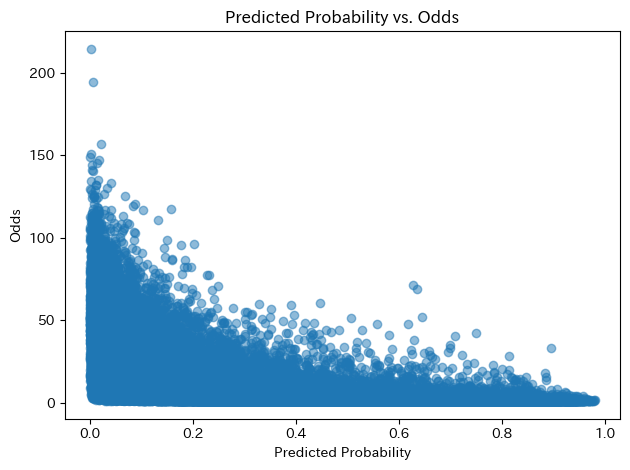

In [26]:
# Create a graph with meta_単勝オッズ on the y-axis and y_proba_1 on the x-axis
fig, ax = plt.subplots()
ax.scatter(payouts["y_proba_1"], payouts["place_odds"], alpha=0.5)
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Odds")
ax.set_title("Predicted Probability vs. Odds")
plt.tight_layout()
plt.show()

In [35]:
payouts.head()

,meta_レースキー,horse_id,position,meta_発走日時,win_odds,place_odds,num_頭数,race_overall_quality,y_test,y_pred,y_proba_1
860787,05114411,06103045,9.0,2011-10-15 15:45:00+09:00,22.8,3.3,11,0.045884,0,0,0.076983
955606,07041402,01105661,7.0,2004-03-14 10:25:00+09:00,22.5,3.5,11,0.035938,0,0,0.260589
602028,06051807,00106675,12.0,2005-01-23 13:20:00+09:00,75.1,12.4,16,0.000768,0,0,0.039184
829306,10022103,99104335,1.0,2002-07-13 10:55:00+09:00,1.4,1.0,18,0.000077,1,1,0.722021
403445,05113403,08104083,2.0,2011-05-29 10:55:00+09:00,3.9,1.4,15,0.002514,1,1,0.513772


In [49]:
# Try
# Betting on only very fair races
# Betting on only very unfair races
payouts = (
    X_test[["meta_レースキー", "meta_血統登録番号", "meta_着順", "meta_発走日時", "meta_単勝オッズ", "meta_複勝オッズ", "num_頭数", "race_overall_quality"]]
    .assign(meta_発走日時=lambda x: pd.to_datetime(x["meta_発走日時"]))
    .assign(y_test=y_test, y_pred=y_pred, y_proba_1=y_proba[:, 1])
    .rename(columns={"meta_複勝オッズ": "place_odds", "meta_着順": "position", "meta_血統登録番号": "horse_id", "meta_単勝オッズ": "win_odds"})
)

bets = []
for i, (race_key, group) in enumerate(payouts.groupby("meta_レースキー")):

    for row in group.itertuples():
        if row.y_proba_1 >= 0.5 and row.win_odds >= 70:
            bets.append([race_key, row.horse_id, True])

    # if len(group) < 2:
    #     continue
    # p1 = group.sort_values("y_proba_1", ascending=False).iloc[0]
    # # p2 = group.sort_values("y_proba_1", ascending=False).iloc[1]
    # requirements = [
    #     # p1.y_pred == 1,
    #     p1.y_proba_1 >= 0.7,
    #     p1["meta_複勝オッズ"] >= 100,
    # ]
    # if all(requirements):
    #     bets.append([race_key, p1["meta_血統登録番号"], True])

payouts = payouts.merge(
    pd.DataFrame(bets, columns=["meta_レースキー", "horse_id", "bet"]),
    on=["meta_レースキー", "horse_id"],
    how="left",
).fillna({"bet": False})

In [50]:
len(bets)

258

In [51]:
(
    payouts
    .assign(hit_f=lambda x: x["bet"] & (x["position"] <= 3))
    .assign(miss_f=lambda x: x["bet"] & ~x["hit_f"])
    .assign(payout_f=lambda x: x["hit_f"] * (x["place_odds"] * 100 - 100) - x["miss_f"] * 100)

    .assign(hit_t=lambda x: x["bet"] & (x["position"] == 1))
    .assign(miss_t=lambda x: x["bet"] & ~x["hit_t"])
    .assign(payout_t=lambda x: x["hit_t"] * (x["win_odds"] * 100 - 100) - x["miss_t"] * 100)

    # .reset_index(drop=True)
    .sort_values(["meta_発走日時", "meta_レースキー"])
    # .dropna(subset=["win_odds", "place_odds"])
)[["payout_t", "payout_f"]].sum()

payout_t    14060.0
payout_f   -11420.0
dtype: float64

In [40]:
# It works!!